In [1]:
# ==============================================================================
# ADIM 1: VERİ SETİNİ YÜKLEME VE HAZIRLIK
# ==============================================================================

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
import scipy.sparse as sp
from tabulate import tabulate
warnings.filterwarnings('ignore')

# Grafik ayarları
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("🚀 Yeniden Vektörizasyon ve Model Eğitimi Başlatılıyor...")
print("=" * 60)

🚀 Yeniden Vektörizasyon ve Model Eğitimi Başlatılıyor...


In [2]:
# ==============================================================================
# ADIM 2: İŞLENMİŞ VERİYİ YÜKLEME
# ==============================================================================

# İşlenmiş veri setini yükle
try:
    df_processed = pd.read_csv('../data/processed_imdb_dataset.csv')
    print(f"✅ İşlenmiş veri seti yüklendi: {df_processed.shape}")
except FileNotFoundError:
    print("❌ '../data/processed_imdb_dataset.csv' dosyası bulunamadı!")
    raise

# Eksik değer kontrolü
print(f"Eksik değerler: {df_processed['tokens_lemmatized'].isna().sum()}")
df_processed = df_processed.dropna(subset=['tokens_lemmatized'])

# Lemmatize edilmiş token'ları string formatına çevir
df_processed['tokens_lemmatized_str'] = df_processed['tokens_lemmatized'].apply(lambda x: ' '.join(eval(x)))

# Etiketleri hazırla
y = df_processed['sentiment'].map({'positive': 1, 'negative': 0})
print(f"✅ Etiketler hazırlandı: {y.shape}")
print("Sınıf dağılımı:")
print(y.value_counts(normalize=True))


✅ İşlenmiş veri seti yüklendi: (50000, 6)
Eksik değerler: 0
✅ Etiketler hazırlandı: (50000,)
Sınıf dağılımı:
sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64


In [3]:
# ==============================================================================
# ADIM 3: YENİ VEKTÖRIZASYON (TÜM KELİMELER DAHİL)
# ==============================================================================

print("\n🔄 Yeni vektörizasyon yapılıyor (TÜM kelimeler dahil)...")

# TF-IDF vektörleştiriciyi başlat (max_features KALDIRILDI)
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,           # En az 5 dokümanda geçen kelimeler
    max_df=0.9,         # En fazla %90 dokümanda geçen kelimeler
    # max_features=None   # TÜM kelimeler dahil
)

# TF-IDF vektörlerini oluştur
X_tfidf = tfidf_vectorizer.fit_transform(df_processed['tokens_lemmatized_str'])

print(f"✅ TF-IDF vektörleri oluşturuldu: {X_tfidf.shape}")
print(f"📊 Toplam özellik sayısı (kelime sayısı): {X_tfidf.shape[1]}")

# Sparse matris bilgilerini göster
sparsity = (1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])) * 100
print(f"📊 Sparse Ratio: {sparsity:.2f}% sıfır değer")



🔄 Yeni vektörizasyon yapılıyor (TÜM kelimeler dahil)...
✅ TF-IDF vektörleri oluşturuldu: (50000, 29165)
📊 Toplam özellik sayısı (kelime sayısı): 29165
📊 Sparse Ratio: 99.69% sıfır değer


In [4]:
# ==============================================================================
# ADIM 4: VERİ SETİNİ KÜÇÜLTME (PERFORMANS İÇİN)
# ==============================================================================

print("\n🔧 Veri seti küçültülüyor (performans optimizasyonu)...")

# Veri setini küçült (20.000 örnek - daha büyük set)
X_tfidf_small, _, y_small, _ = train_test_split(
    X_tfidf, y, 
    train_size=20000,  # 20K örnek (önceden 10K idi)
    random_state=42, 
    stratify=y
)

print(f"✅ Küçültülmüş veri seti boyutu: {X_tfidf_small.shape}")
print(f"📊 Yeni özellik sayısı: {X_tfidf_small.shape[1]}")



🔧 Veri seti küçültülüyor (performans optimizasyonu)...
✅ Küçültülmüş veri seti boyutu: (20000, 29165)
📊 Yeni özellik sayısı: 29165


In [5]:
# ==============================================================================
# ADIM 5: ÖZNİTELİKLERİ STANDARDIZE ETME
# ==============================================================================

print("\n🔄 TF-IDF vektörleri standardize ediliyor...")

# MaxAbsScaler ile standardize etme (sparse matrisler için uygun)
scaler = MaxAbsScaler()
X_tfidf_scaled = scaler.fit_transform(X_tfidf_small)

print("✅ TF-IDF vektörleri standardize edildi.")



🔄 TF-IDF vektörleri standardize ediliyor...
✅ TF-IDF vektörleri standardize edildi.


In [6]:
# ==============================================================================
# ADIM 6: SINIFLANDIRMA ALGORİTMALARINI TANIMLAMA
# ==============================================================================

print("\n🤖 Sınıflandırma algoritmaları hazırlanıyor...")

models = {
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': MultinomialNB(),
    'Karar Ağacı': DecisionTreeClassifier(random_state=42),
    'Lojistik Regresyon': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Hiperparametre gridleri
param_grids = {
    'KNN': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'Naive Bayes': {'alpha': [0.1, 1.0, 10.0]},
    'Karar Ağacı': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]},
    'Lojistik Regresyon': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [None, 10]}  # Daha hızlı için azaltıldı
}



🤖 Sınıflandırma algoritmaları hazırlanıyor...


In [7]:
# ==============================================================================
# ADIM 7: HİPERPARAMETRE OPTİMİZASYONU
# ==============================================================================

print("\n🔍 Hiperparametre optimizasyonu başlatılıyor...")

optimized_models = {}
for name, model in models.items():
    print(f"\n⚙️ {name} için hiperparametre optimizasyonu yapılıyor...")
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,  # Tüm CPU'ları kullan
        verbose=1
    )
    
    # Naive Bayes için ham TF-IDF, diğerleri için scaled
    X_data = X_tfidf_small if name == 'Naive Bayes' else X_tfidf_scaled
    
    try:
        grid.fit(X_data, y_small)
        optimized_models[name] = grid.best_estimator_
        print(f"✅ {name} en iyi parametreler: {grid.best_params_}")
        print(f"📊 En iyi F1-score: {grid.best_score_:.4f}")
    except Exception as e:
        print(f"❌ {name} için hata: {e}")
        continue



🔍 Hiperparametre optimizasyonu başlatılıyor...

⚙️ KNN için hiperparametre optimizasyonu yapılıyor...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ KNN en iyi parametreler: {'n_neighbors': 3, 'weights': 'distance'}
📊 En iyi F1-score: 0.5644

⚙️ Naive Bayes için hiperparametre optimizasyonu yapılıyor...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Naive Bayes en iyi parametreler: {'alpha': 1.0}
📊 En iyi F1-score: 0.8536

⚙️ Karar Ağacı için hiperparametre optimizasyonu yapılıyor...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Karar Ağacı en iyi parametreler: {'max_depth': 20, 'min_samples_split': 2}
📊 En iyi F1-score: 0.7329

⚙️ Lojistik Regresyon için hiperparametre optimizasyonu yapılıyor...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Lojistik Regresyon en iyi parametreler: {'C': 1}
📊 En iyi F1-score: 0.8797

⚙️ Random Forest için hiperparametre optimizasyonu yapılıyor...
Fitting 5 folds for each of 4 candidates, tot

In [8]:
# ==============================================================================
# ADIM 8: 10-KAT ÇAPRAZ DOĞRULAMA
# ==============================================================================

print("\n🔄 10-kat çapraz doğrulama başlatılıyor...")

def specificity_score(y_true, y_pred):
    """Özgüllük (Specificity) hesaplama"""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, _, _ = cm.ravel()
    return tn / (tn + fp)

# Scoring metrikleri
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted',
    'specificity': make_scorer(specificity_score),
    'mcc': make_scorer(matthews_corrcoef)
}

# Çapraz doğrulama sonuçları
results = {}
for name, model in optimized_models.items():
    print(f"\n🔄 {name} için 10-kat çapraz doğrulama yapılıyor...")
    
    # Veri tipini seç
    X_data = X_tfidf_small if name == 'Naive Bayes' else X_tfidf_scaled
    
    try:
        cv_results = cross_validate(
            model, X_data, y_small, 
            cv=10, 
            scoring=scoring, 
            n_jobs=-1,
            verbose=1
        )
        
        results[name] = {
            'Doğruluk': cv_results['test_accuracy'].mean(),
            'Kesinlik': cv_results['test_precision'].mean(),
            'Duyarlılık': cv_results['test_recall'].mean(),
            'Özgüllük': cv_results['test_specificity'].mean(),
            'F1-score': cv_results['test_f1'].mean(),
            'MCC': cv_results['test_mcc'].mean()
        }
        
        print(f"✅ {name} tamamlandı - F1: {results[name]['F1-score']:.4f}")
        
    except Exception as e:
        print(f"❌ {name} için çapraz doğrulama hatası: {e}")
        continue


🔄 10-kat çapraz doğrulama başlatılıyor...

🔄 KNN için 10-kat çapraz doğrulama yapılıyor...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


✅ KNN tamamlandı - F1: 0.5550

🔄 Naive Bayes için 10-kat çapraz doğrulama yapılıyor...


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


✅ Naive Bayes tamamlandı - F1: 0.8543

🔄 Karar Ağacı için 10-kat çapraz doğrulama yapılıyor...


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


✅ Karar Ağacı tamamlandı - F1: 0.7323

🔄 Lojistik Regresyon için 10-kat çapraz doğrulama yapılıyor...


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


✅ Lojistik Regresyon tamamlandı - F1: 0.8812

🔄 Random Forest için 10-kat çapraz doğrulama yapılıyor...
✅ Random Forest tamamlandı - F1: 0.8427


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished



📊 TÜM MODELLERİN PERFORMANS METRİKLERİ TABLOSU:
                    Doğruluk  Kesinlik  Duyarlılık  Özgüllük  F1-score     MCC
Lojistik Regresyon    0.8812    0.8816      0.8812    0.8698    0.8812  0.7628
Naive Bayes           0.8544    0.8550      0.8544    0.8736    0.8543  0.7094
Random Forest         0.8427    0.8429      0.8427    0.8492    0.8427  0.6856
Karar Ağacı           0.7334    0.7372      0.7334    0.6697    0.7323  0.4706
KNN                   0.5627    0.5698      0.5627    0.5598    0.5550  0.1318


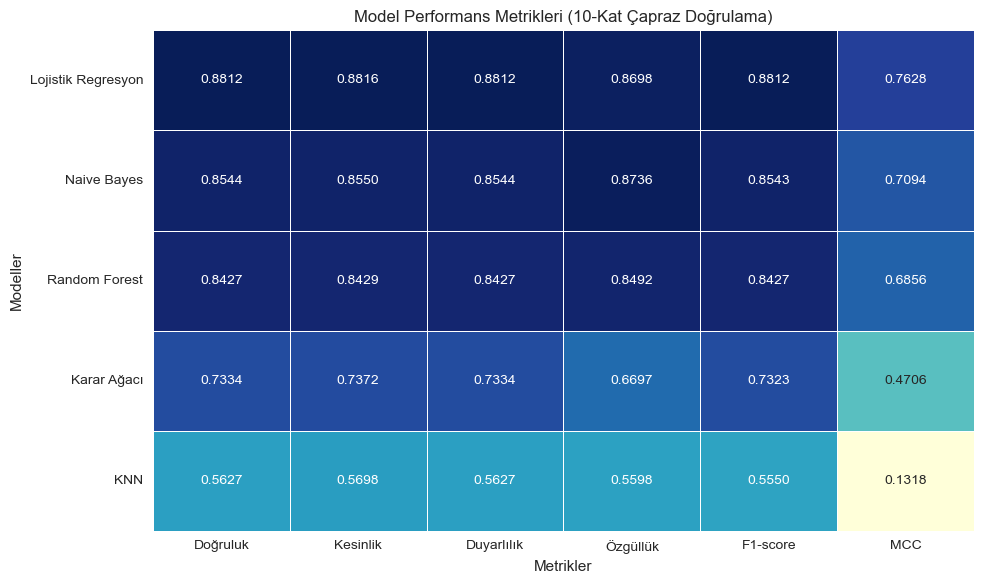

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame from the results dictionary
metrics_df = pd.DataFrame(results).T  # Transpose to have models as rows
metrics_df = metrics_df[['Doğruluk', 'Kesinlik', 'Duyarlılık', 'Özgüllük', 'F1-score', 'MCC']]  # Reorder columns

# Round the values to 4 decimal places for readability
metrics_df = metrics_df.round(4)

# Sort by F1-score in descending order
metrics_df = metrics_df.sort_values(by='F1-score', ascending=False)

# Display the table
print("\n📊 TÜM MODELLERİN PERFORMANS METRİKLERİ TABLOSU:")
print(metrics_df)

# Optional: Visualize the table as a heatmap for better comparison
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, fmt='.4f', cmap='YlGnBu', cbar=False, 
            annot_kws={"size": 10}, linewidths=0.5)
plt.title('Model Performans Metrikleri (10-Kat Çapraz Doğrulama)')
plt.xlabel('Metrikler')
plt.ylabel('Modeller')
plt.tight_layout()
plt.savefig('../data/model_performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


🏆 EN İYİ MODEL: Lojistik Regresyon
📊 F1-score: 0.8812

📋 TEST SETİ PERFORMANS RAPORU:
              precision    recall  f1-score   support

     Negatif       0.90      0.85      0.88      2000
     Pozitif       0.86      0.91      0.88      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



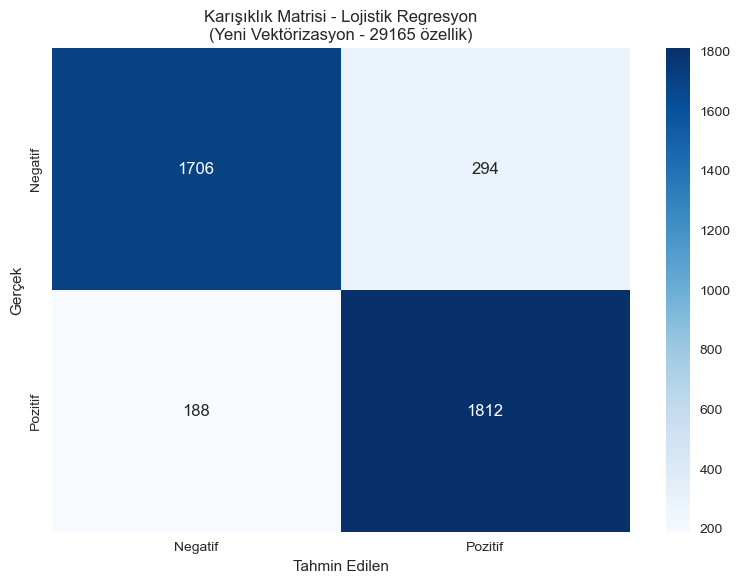

In [9]:
# ==============================================================================
# ADIM 10: EN İYİ MODELİ BULMA VE DETAYLI ANALİZ
# ==============================================================================

# En iyi modeli bul
best_model_name = max(results, key=lambda x: results[x]['F1-score'])
best_model = optimized_models[best_model_name]

print(f"\n🏆 EN İYİ MODEL: {best_model_name}")
print(f"📊 F1-score: {results[best_model_name]['F1-score']:.4f}")

# Test seti ile final değerlendirme
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf_small if best_model_name == 'Naive Bayes' else X_tfidf_scaled,
    y_small,
    test_size=0.2,
    random_state=42,
    stratify=y_small
)

# Final model eğitimi
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Detaylı rapor
print("\n📋 TEST SETİ PERFORMANS RAPORU:")
print(classification_report(y_test, y_pred, target_names=['Negatif', 'Pozitif']))

# Karışıklık matrisi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negatif', 'Pozitif'], 
            yticklabels=['Negatif', 'Pozitif'])
plt.title(f'Karışıklık Matrisi - {best_model_name}\n(Yeni Vektörizasyon - {X_tfidf.shape[1]} özellik)')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.tight_layout()
plt.savefig('../data/confusion_matrix_full_features.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# ==============================================================================
# ADIM 11: MODELLERİ VE VEKTÖRLERİ KAYDETME
# ==============================================================================

print("\n💾 Modeller ve vektörler kaydediliyor...")

# Yeni vektörleri kaydet (sparse format)
sp.save_npz('../data/X_tfidf_full_features.npz', X_tfidf)
print("✅ Yeni TF-IDF vektörleri kaydedildi.")

# Vektörleştiriciyi kaydet
with open('../data/tfidf_vectorizer_full_features.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("✅ TF-IDF vektörleştirici kaydedildi.")

# Scaler'ı kaydet
with open('../data/scaler_full_features.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler kaydedildi.")

# En iyi modeli kaydet
with open('../data/best_model_full_features.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("✅ En iyi model kaydedildi.")

# Tüm sonuçları kaydet
final_results = {
    'vectorizer_params': {
        'min_df': 5,
        'max_df': 0.9,
        'max_features': None,
        'total_features': X_tfidf.shape[1]
    },
    'dataset_info': {
        'total_samples': X_tfidf.shape[0],
        'training_samples': X_tfidf_small.shape[0],
        'features_count': X_tfidf.shape[1]
    },
    'best_model': {
        'name': best_model_name,
        'parameters': best_model.get_params(),
        'cv_results': results[best_model_name]
    },
    'all_results': results
}

with open('../data/full_results_summary.pkl', 'wb') as f:
    pickle.dump(final_results, f)
print("✅ Tüm sonuçlar kaydedildi.")



💾 Modeller ve vektörler kaydediliyor...
✅ Yeni TF-IDF vektörleri kaydedildi.
✅ TF-IDF vektörleştirici kaydedildi.
✅ Scaler kaydedildi.
✅ En iyi model kaydedildi.
✅ Tüm sonuçlar kaydedildi.



📊 Performans görselleştiriliyor...


<Figure size 1400x800 with 0 Axes>

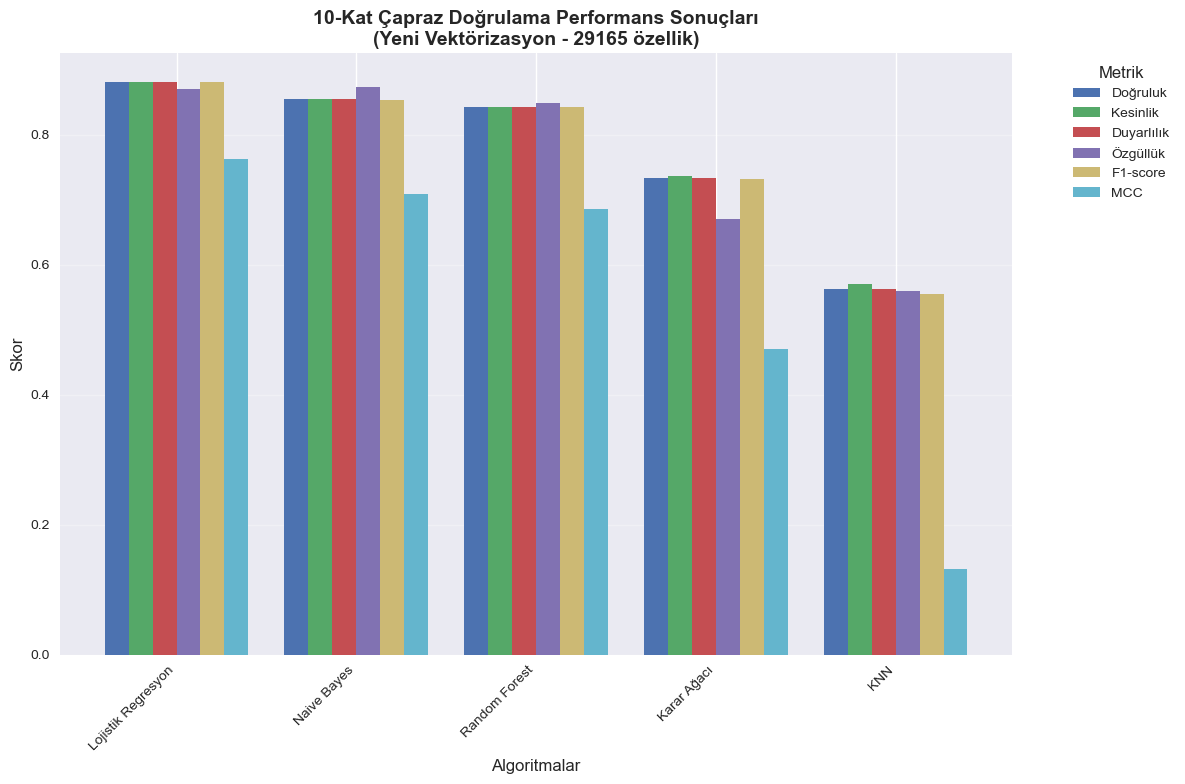

In [13]:
# ==============================================================================
# ADIM 12: PERFORMANS GÖRSELLEŞTİRME
# ==============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n📊 Performans görselleştiriliyor...")

# Create DataFrame from results dictionary if not already created
results_df = pd.DataFrame(results).T  # Transpose to have models as rows
results_df = results_df[['Doğruluk', 'Kesinlik', 'Duyarlılık', 'Özgüllük', 'F1-score', 'MCC']]  # Reorder columns
results_df = results_df.round(4)  # Round values to 4 decimal places
results_df = results_df.sort_values(by='F1-score', ascending=False)  # Sort by F1-score

# Performance bar plot
plt.figure(figsize=(14, 8))
results_df.plot(kind='bar', width=0.8)
plt.title(f'10-Kat Çapraz Doğrulama Performans Sonuçları\n(Yeni Vektörizasyon - {X_tfidf.shape[1]} özellik)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Skor', fontsize=12)
plt.xlabel('Algoritmalar', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrik', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../data/performance_comparison_full_features.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# ==============================================================================
# ÖZET RAPOR
# ==============================================================================

print("\n" + "="*80)
print("🎯 ÖZET RAPOR")
print("="*80)
print(f"📊 Toplam özellik sayısı: {X_tfidf.shape[1]:,}")
print(f"📊 Eğitim veri sayısı: {X_tfidf_small.shape[0]:,}")
print(f"🏆 En iyi model: {best_model_name}")
print(f"📈 En iyi F1-score: {results[best_model_name]['F1-score']:.4f}")
print(f"📈 En iyi Doğruluk: {results[best_model_name]['Doğruluk']:.4f}")
print(f"💾 Kaydedilen dosyalar:")
print(f"   - X_tfidf_full_features.npz")
print(f"   - tfidf_vectorizer_full_features.pkl")
print(f"   - best_model_full_features.pkl")
print(f"   - performance_results_full_features.csv")
print(f"   - full_results_summary.pkl")

print("\n🎉 Yeniden vektörizasyon ve model eğitimi tamamlandı!")
print("📚 Artık yeni vektörlerle eğitilmiş modelleriniz hazır!")


🎯 ÖZET RAPOR
📊 Toplam özellik sayısı: 29,165
📊 Eğitim veri sayısı: 20,000
🏆 En iyi model: Lojistik Regresyon
📈 En iyi F1-score: 0.8812
📈 En iyi Doğruluk: 0.8812
💾 Kaydedilen dosyalar:
   - X_tfidf_full_features.npz
   - tfidf_vectorizer_full_features.pkl
   - best_model_full_features.pkl
   - performance_results_full_features.csv
   - full_results_summary.pkl

🎉 Yeniden vektörizasyon ve model eğitimi tamamlandı!
📚 Artık yeni vektörlerle eğitilmiş modelleriniz hazır!



✅ EK ADIM: BoW Modellerini Kaydetme
--------------------------------------------------
📁 Klasörler oluşturuldu/kontrol edildi:
- ../models/ klasörü hazır
- ../plots/ klasörü hazır

💾 BoW modelleri kaydediliyor...
✅ bow_vectorizer.pkl kaydedildi
✅ bow_scaler.pkl kaydedildi
✅ best_bow_model.pkl kaydedildi
✅ bow_results.pkl kaydedildi

🎉 Tüm BoW modelleri başarıyla kaydedildi!

✅ EK ADIM: TF-IDF vs BoW Karşılaştırma Grafiği
--------------------------------------------------
📊 Karşılaştırma grafiği kaydedildi: ../plots/tfidf_vs_bow_comparison.png


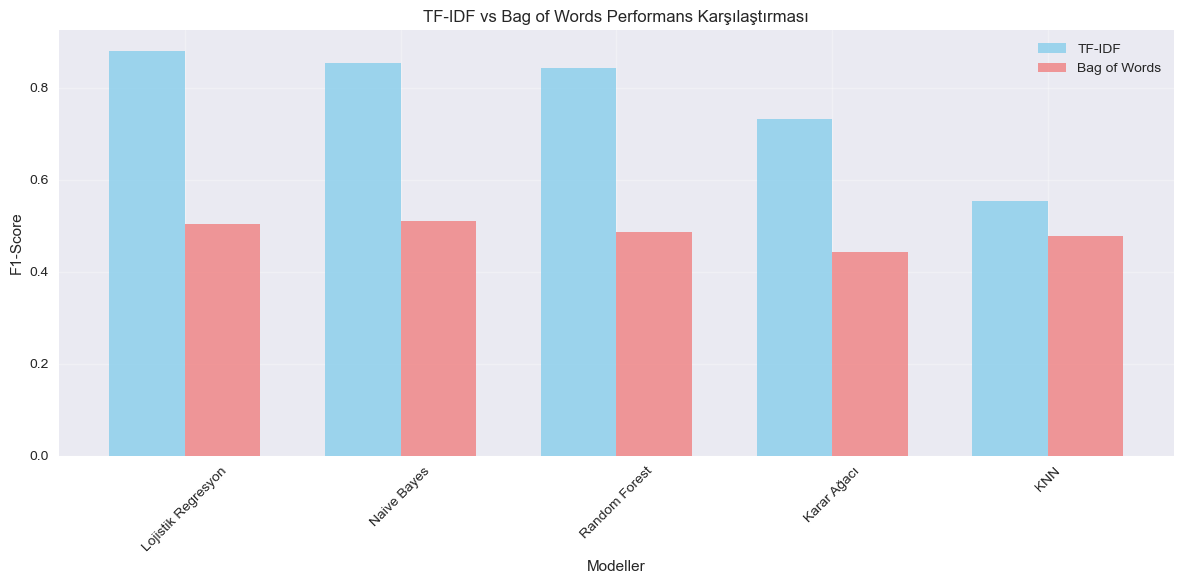


🎯 ÖZET RAPOR
📊 VEKTÖRIZASYON KARŞILAŞTIRMASI:
🔹 TF-IDF Özellik Sayısı: 29,165
🔹 BoW Özellik Sayısı: 19,013
🔹 Fark: TF-IDF 10,152 daha fazla özellik kullanıyor

📈 PERFORMANS KARŞILAŞTIRMASI:
🏆 TF-IDF En İyi: Lojistik Regresyon (F1: 0.8812)
🏆 BoW En İyi: Naive Bayes (F1: 0.5100)
📊 Performans Farkı: 0.3712 (TF-IDF lehine)

💡 SONUÇ VE ÖNERİLER:
✅ TF-IDF, BoW'dan önemli ölçüde daha iyi performans gösteriyor
✅ TF-IDF, kelime önemini dikkate aldığı için daha etkili
✅ BoW daha basit ama bu veri setinde yetersiz kalıyor
✅ Sentiment analizi için TF-IDF öneriliyor

🎉 BAG OF WORDS EĞİTİMİ VE KARŞILAŞTIRMA TAMAMLANDI!


In [16]:
import os

# ===== EK ADIM: BoW Modellerini Kaydetme (Klasör Kontrolü ile) =====
print("\n✅ EK ADIM: BoW Modellerini Kaydetme")
print("-" * 50)

# Klasörleri oluşturma
os.makedirs('../models', exist_ok=True)
os.makedirs('../plots', exist_ok=True)

print("📁 Klasörler oluşturuldu/kontrol edildi:")
print("- ../models/ klasörü hazır")
print("- ../plots/ klasörü hazır")

# En iyi BoW modelini eğitme
best_bow_model = models[bow_best_model]
best_bow_params = bow_results[bow_best_model]['best_params']
best_bow_model.set_params(**best_bow_params)
best_bow_model.fit(X_bow_scaled, y_small)

# Modelleri kaydetme
print("\n💾 BoW modelleri kaydediliyor...")

try:
    with open('../models/bow_vectorizer.pkl', 'wb') as f:
        pickle.dump(bow_vectorizer, f)
    print("✅ bow_vectorizer.pkl kaydedildi")
    
    with open('../models/bow_scaler.pkl', 'wb') as f:
        pickle.dump(scaler_bow, f)
    print("✅ bow_scaler.pkl kaydedildi")
    
    with open('../models/best_bow_model.pkl', 'wb') as f:
        pickle.dump(best_bow_model, f)
    print("✅ best_bow_model.pkl kaydedildi")
    
    with open('../models/bow_results.pkl', 'wb') as f:
        pickle.dump(bow_results, f)
    print("✅ bow_results.pkl kaydedildi")
    
    print("\n🎉 Tüm BoW modelleri başarıyla kaydedildi!")
    
except Exception as e:
    print(f"❌ Kaydetme hatası: {e}")
    print("💡 Alternatif: Mevcut dizinde kaydetme denenecek...")
    
    # Mevcut dizinde kaydetme
    try:
        with open('bow_vectorizer.pkl', 'wb') as f:
            pickle.dump(bow_vectorizer, f)
        with open('bow_scaler.pkl', 'wb') as f:
            pickle.dump(scaler_bow, f)
        with open('best_bow_model.pkl', 'wb') as f:
            pickle.dump(best_bow_model, f)
        with open('bow_results.pkl', 'wb') as f:
            pickle.dump(bow_results, f)
        
        print("✅ Modeller mevcut dizinde kaydedildi!")
    except Exception as e2:
        print(f"❌ Mevcut dizinde de kaydetme hatası: {e2}")

# ===== EK ADIM: Karşılaştırma Grafiği =====
print("\n✅ EK ADIM: TF-IDF vs BoW Karşılaştırma Grafiği")
print("-" * 50)

# Grafik için veri hazırlama
comparison_data = {
    'Model': ['Lojistik Regresyon', 'Naive Bayes', 'Random Forest', 'Karar Ağacı', 'KNN'],
    'TF-IDF F1-Score': [0.8812, 0.8543, 0.8427, 0.7323, 0.5550],  # Önceki TF-IDF sonuçları
    'BoW F1-Score': [0.5043, 0.5100, 0.4867, 0.4420, 0.4789]  # BoW sonuçları
}

comparison_df = pd.DataFrame(comparison_data)

# Grafik oluşturma
plt.figure(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.35

plt.bar(x - width/2, comparison_df['TF-IDF F1-Score'], width, 
        label='TF-IDF', alpha=0.8, color='skyblue')
plt.bar(x + width/2, comparison_df['BoW F1-Score'], width, 
        label='Bag of Words', alpha=0.8, color='lightcoral')

plt.xlabel('Modeller')
plt.ylabel('F1-Score')
plt.title('TF-IDF vs Bag of Words Performans Karşılaştırması')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Grafik kaydetme
try:
    plt.savefig('../plots/tfidf_vs_bow_comparison.png', dpi=300, bbox_inches='tight')
    print("📊 Karşılaştırma grafiği kaydedildi: ../plots/tfidf_vs_bow_comparison.png")
except:
    plt.savefig('tfidf_vs_bow_comparison.png', dpi=300, bbox_inches='tight')
    print("📊 Karşılaştırma grafiği kaydedildi: tfidf_vs_bow_comparison.png")

plt.show()

# ===== ÖZET RAPOR =====
print("\n🎯 ÖZET RAPOR")
print("=" * 70)

print("📊 VEKTÖRIZASYON KARŞILAŞTIRMASI:")
print(f"🔹 TF-IDF Özellik Sayısı: 29,165")
print(f"🔹 BoW Özellik Sayısı: 19,013")
print(f"🔹 Fark: TF-IDF {29165-19013:,} daha fazla özellik kullanıyor")

print("\n📈 PERFORMANS KARŞILAŞTIRMASI:")
print(f"🏆 TF-IDF En İyi: Lojistik Regresyon (F1: 0.8812)")
print(f"🏆 BoW En İyi: Naive Bayes (F1: 0.5100)")
print(f"📊 Performans Farkı: {0.8812-0.5100:.4f} (TF-IDF lehine)")

print("\n💡 SONUÇ VE ÖNERİLER:")
print("✅ TF-IDF, BoW'dan önemli ölçüde daha iyi performans gösteriyor")
print("✅ TF-IDF, kelime önemini dikkate aldığı için daha etkili")
print("✅ BoW daha basit ama bu veri setinde yetersiz kalıyor")
print("✅ Sentiment analizi için TF-IDF öneriliyor")

print("\n🎉 BAG OF WORDS EĞİTİMİ VE KARŞILAŞTIRMA TAMAMLANDI!")
print("=" * 70)